In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("divyansh22/dummy-astronomy-data")

print("Path to dataset files:", path)

100%|██████████| 8.46M/8.46M [00:00<00:00, 114MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/divyansh22/dummy-astronomy-data/versions/4


In [2]:
import os

files = os.listdir(path)
print("Files:", files)
galaxy_folder = os.path.join(path, "Cutout Files", "galaxy")
star_folder = os.path.join(path, "Cutout Files", "star")

print("Galaxy folder:", galaxy_folder)
print("List of galaxy images:", os.listdir(galaxy_folder))
print("Star folder:", star_folder)
print("List of star images:", os.listdir(star_folder))

Files: ['Cutout Files']
Galaxy folder: /root/.cache/kagglehub/datasets/divyansh22/dummy-astronomy-data/versions/4/Cutout Files/galaxy
List of galaxy images: ['J142943p385931_001_001_1067_1615_3.jpg', 'J125219p264053_001_010_1172_1897_3.jpg', 'J1603p3002_001_010_1033_1570_3.jpg', 'J153044p231014_001_001_371_204_3.jpg', 'j1612p5118_r_01_1067_1244_3.jpg', 'J125219p264053_001_010_256_1854_3.jpg', 'J1603p3002_001_010_769_1006_3.jpg', 'J153044p231014_001_001_826_1723_3.jpg', 'j1612p5118_r_01_506_1164_3.jpg', 'J153044p231014_001_001_104_488_3.jpg', 'WASP-24_R01_1897_137_3.jpg', 'J121929p47152_001_010_937_172_3.jpg', 'J153044p231014_001_001_1058_593_3.jpg', 'J1252p2640_r_01_10_1290_1275_3.jpg', 'J125219p264053_001_010_1086_297_3.jpg', 'J142943p385931_001_001_1171_1853_3.jpg', 'J125219p264053_001_010_1079_1523_3.jpg', 'UM439-H01_498_778_3.jpg', 'J125219p264053_001_010_380_626_3.jpg', 'J161245p511816_001_010_229_1024_3.jpg', 'j1612p5118_r_01_833_837_3.jpg', 'J1252p2640_r_01_10_1349_1245_3.jpg', 

In [3]:
galaxy_images_paths = [os.path.join(galaxy_folder, f) for f in os.listdir(galaxy_folder)]
star_images_paths = [os.path.join(star_folder, f) for f in os.listdir(star_folder)]

galaxy_images_names = [os.path.basename(f) for f in galaxy_images_paths]
star_images_names = [os.path.basename(f) for f in star_images_paths]

print("Image paths for galaxies:", galaxy_images_paths[:5])  # Print first 5 galaxy image paths
print("Image paths for stars:", star_images_paths[:5])      # Print first 5 star image paths

print("Number of galaxy images:", len(galaxy_images_paths))
print("Number of star images:", len(star_images_paths))

print(galaxy_images_names[:5])  # Print first 5 galaxy image paths
print(star_images_names[:5])    # Print first 5 star image paths

Image paths for galaxies: ['/root/.cache/kagglehub/datasets/divyansh22/dummy-astronomy-data/versions/4/Cutout Files/galaxy/J142943p385931_001_001_1067_1615_3.jpg', '/root/.cache/kagglehub/datasets/divyansh22/dummy-astronomy-data/versions/4/Cutout Files/galaxy/J125219p264053_001_010_1172_1897_3.jpg', '/root/.cache/kagglehub/datasets/divyansh22/dummy-astronomy-data/versions/4/Cutout Files/galaxy/J1603p3002_001_010_1033_1570_3.jpg', '/root/.cache/kagglehub/datasets/divyansh22/dummy-astronomy-data/versions/4/Cutout Files/galaxy/J153044p231014_001_001_371_204_3.jpg', '/root/.cache/kagglehub/datasets/divyansh22/dummy-astronomy-data/versions/4/Cutout Files/galaxy/j1612p5118_r_01_1067_1244_3.jpg']
Image paths for stars: ['/root/.cache/kagglehub/datasets/divyansh22/dummy-astronomy-data/versions/4/Cutout Files/star/J140012p353930_001_001_1030_930_6.jpg', '/root/.cache/kagglehub/datasets/divyansh22/dummy-astronomy-data/versions/4/Cutout Files/star/WASP-24_R01_1082_1699_6.jpg', '/root/.cache/kaggl

Galaxy Images:


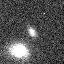

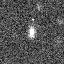

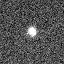

Star Images:


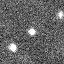

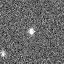

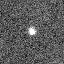

In [11]:
from IPython.display import display
from PIL import Image

# Display first 3 galaxy images
print("Galaxy Images:")
for img_path in galaxy_images_paths[:3]:
    img = Image.open(img_path)
    display(img)

# Display first 3 star images
print("Star Images:")
for img_path in star_images_paths[:3]:
    img = Image.open(img_path)
    display(img)

In [4]:
# outpute image sizes
from PIL import Image

galaxy_sizes = [Image.open(img).size for img in galaxy_images_paths[:5]]
star_sizes = [Image.open(img).size for img in star_images_paths[:5]]

print("Galaxy image sizes (first 5):", galaxy_sizes)
print("Star image sizes (first 5):", star_sizes)

Galaxy image sizes (first 5): [(64, 64), (64, 64), (64, 64), (64, 64), (64, 64)]
Star image sizes (first 5): [(64, 64), (64, 64), (64, 64), (64, 64), (64, 64)]


In [5]:
# %pip install tensorflow

In [6]:
# %conda create -n tf_env python=3.10
# %conda activate tf_env

# # Install numpy and dependencies first
# %conda install numpy

# # Install tensorflow from pip (conda's TF on Windows can be old)
# %pip install tensorflow==2.18.0

# # Install image preprocessing libs
# %pip install pillow


In [7]:
# required if compatibility issues arise with protobuf and spacy versions
# %pip install --upgrade protobuf==3.20.3 spacy==3.7.4

In [8]:
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image

#include top = false to exclude the fully connected layers (we only need feature extraction)
vgg16_model = VGG16(weights='imagenet', include_top=False)

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import os

# Create a list to store features and labels
features = []
labels = []

# Process star images
for img_path in star_images_paths:
    processed_img = preprocess_image(img_path)
    # Extract features using the pre-trained VGG16 model
    feature_vector = vgg16_model.predict(processed_img)
    # Flatten the feature vector from 3D to 1D
    feature_vector = feature_vector.flatten()
    features.append(feature_vector)
    labels.append(0)  # Label 0 for stars

# Process galaxy images
for img_path in galaxy_images_paths:
    processed_img = preprocess_image(img_path)
    feature_vector = vgg16_model.predict(processed_img)
    feature_vector = feature_vector.flatten()
    features.append(feature_vector)
    labels.append(1)  # Label 1 for galaxies

# Convert lists to numpy arrays
X = np.array(features)
y = np.array(labels)

# Print the shape of the resulting feature matrix
print(f"Shape of feature matrix X: {X.shape}")
print(f"Shape of labels y: {y.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import numpy as np

# Save the feature matrix X and labels y to files
np.save('features.npy', X)
np.save('labels.npy', y)

print("Feature matrix X saved to features.npy")
print("Labels y saved to labels.npy")